In [168]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import re
import scipy.stats as stats
import seaborn as sns
import ast

sns.set(style='ticks', color_codes = True)


from pandas.plotting import scatter_matrix
import statsmodels.api as sm
from time import time

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import power_transform
from sklearn import preprocessing

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import log_loss, make_scorer
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split, GridSearchCV


sns.set(style='ticks', color_codes = True)

In [60]:
def heatMap(df, filename):
    #Create Correlation df
    corr = df.corr()
    #Plot figsize
    fig, ax = plt.subplots(figsize=(20, 20))
    #Generate Color Map
    colormap = sns.diverging_palette(220, 10, as_cmap=True)
    #Generate Heat Map, allow annotations and place floats in map
    sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f")
    #Apply xticks
    plt.xticks(range(len(corr.columns)), corr.columns);
    #Apply yticks
    plt.yticks(range(len(corr.columns)), corr.columns)
    #show plot
    plt.savefig(filename)
# https://theakway.blog/2018/08/10/linear-regression-with-python-sklearn/

def rss(model,X,y):
    '''
    Function to calculate the residual sum of squared of the model
    Input:
        model: Trained linear regression model
        X: Training predictors as a pandas dataframe
        y: Training responses as a pandas dataframe
    Output:
        The RSS of the model
    '''
    res = y - model.predict(X)
    return sum(res**2)
 
def rse(model,X,y):
    '''
    Function to calculate the residual standard error of the model
    Input:
        model: Trained linear regression model
        X: Training predictors as a pandas dataframe
        y: Training responses as a pandas dataframe
    Output:
        The RSE of the model
    '''
    return np.sqrt(rss(model,X,y)/(X.shape[0]-X.shape[1]-1))
 
def studresidplot(model,X,y,threshold=3,ax=None, **kwargs):
    '''
    This function plots a studentized residual plot
    Inputs:
        model = Trained sklearn model
        X: Predictors as a pandas dataframe
        y: Responses as a pandas dataframe
        Threshold: Threshold to identify outliers
        kwargs: seaborn.residplot arguments
    Output:
        Boolean mask for outliers(False if outlier)
    '''
    vals = {'Studentized Residuals': (y-model.predict(X))/rse(model,X,y), 'Predicted Values': model.predict(X)}
    resdf = pd.DataFrame(vals)
    resdf['Outlier'] = resdf['Studentized Residuals'].apply(lambda x: 'Outlier' if abs(x)>= threshold else 'Normal')
    #ax = sns.lmplot(y='Studentized Residuals',x='Predicted Values', hue='Outlier' , data=resdf, fit_reg=False, **kwargs)
    ax = sns.scatterplot(y='Studentized Residuals',x='Predicted Values', hue='Outlier' , data=resdf, ax=ax, **kwargs)
    return resdf['Studentized Residuals'].apply(lambda x: False if abs(x)>= 3 else True)

# Input 

In [61]:
df = pd.read_csv('seatgeek_ticket_info.csv')
df.head()

/Users/linhchau/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (10,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Unnamed: 0 access_method        announce_date  \
0           0           NaN  2019-01-23T00:00:00   
1           1           NaN  2018-12-20T00:00:00   
2           2           NaN  2019-05-02T00:00:00   
3           3           NaN  2019-05-14T00:00:00   
4           4           NaN  2019-08-24T00:00:00   

                                       announcements  conditional  \
0  {'checkout_disclosures': {'messages': [{'text'...        False   
1  {'checkout_disclosures': {'messages': [{'text'...        False   
2                                                 {}        False   
3                                                 {}        False   
4                                                 {}        False   

            created_at  date_tbd       datetime_local  datetime_tbd  \
0  2019-01-23T16:10:16     False  2019-10-08T03:30:00         False   
1  2018-12-20T16:11:07     False  2019-10-08T03:30:00         False   
2  2019-05-02T16:16:35     False  2019-10-08T19:30:00         False   
3  2019-05-14T02:59:07     False  2019-10-08T18:30:00         False   
4  2019-08-24T16:02:30     False  2019-10-08T20:30:00         False   

          datetime_utc  ...                           venue_name_v2  \
0  2019-10-08T10:30:00  ...  Le Theatre Des Arts at Paris Las Vegas   
1  2019-10-08T10:30:00  ...           High Roller Wheel At the LINQ   
2  2019-10-09T01:30:00  ...                        Colonial Theater   
3  2019-10-09T01:30:00  ...                House of Blues - Anaheim   
4  2019-10-09T01:30:00  ...                               Gasa Gasa   

   venue_num_upcoming_events  venue_popularity venue_postal_code  venue_score  \
0                        161                 0             89109     0.453888   
1                        158                 0             89109     0.000000   
2                          1                 0             83402     0.394669   
3                         52                 0             92802     0.544078   
4                         30                 0             70115     0.354410   

                               venue_slug venue_state       venue_timezone  \
0  le-theatre-des-arts-at-paris-las-vegas          NV  America/Los_Angeles   
1           high-roller-wheel-at-the-linq          NV  America/Los_Angeles   
2                      colonial-theater-2          ID        America/Boise   
3                  house-of-blues-anaheim          CA  America/Los_Angeles   
4                               gasa-gasa          LA      America/Chicago   

                                           venue_url    visible_until_utc  
0  https://seatgeek.com/venues/le-theatre-des-art...  2019-10-09T07:00:00  
1  https://seatgeek.com/venues/high-roller-wheel-...  2019-10-09T07:00:00  
2  https://seatgeek.com/venues/colonial-theater-2...  2019-10-09T05:30:00  
3  https://seatgeek.com/venues/house-of-blues-ana...  2019-10-09T05:30:00  
4      https://seatgeek.com/venues/gasa-gasa/tickets  2019-10-09T05:30:00  

[5 rows x 90 columns]

In [62]:
df.shape

(114368, 90)

In [63]:
df.drop(df.columns[0], axis=1, inplace=True)

In [64]:
df[['stats_average_price',
       'stats_dq_bucket_counts', 'stats_highest_price', 'stats_listing_count',
       'stats_lowest_price', 'stats_lowest_price_good_deals',
       'stats_lowest_sg_base_price', 'stats_lowest_sg_base_price_good_deals',
       'stats_median_price', 'stats_variants', 'stats_visible_listing_count']]

stats_average_price    stats_dq_bucket_counts  stats_highest_price  \
0                      56.0  [0, 0, 0, 0, 0, 0, 0, 0]                 63.0   
1                      65.0  [0, 0, 0, 0, 0, 0, 0, 0]                109.0   
2                     254.0  [0, 0, 0, 0, 0, 0, 0, 0]                293.0   
3                      22.0  [0, 0, 0, 0, 0, 0, 0, 0]                 22.0   
4                      62.0  [0, 0, 0, 0, 0, 0, 0, 0]                 62.0   
5                      56.0  [0, 0, 0, 0, 0, 0, 0, 0]                 67.0   
6                       NaN                       NaN                  NaN   
7                      38.0  [1, 1, 0, 0, 0, 1, 1, 7]                 72.0   
8                       NaN                       NaN                  NaN   
9                       NaN                       NaN                  NaN   
10                      NaN                       NaN                  NaN   
11                     58.0  [0, 0, 0, 0, 0, 0, 0, 0]                 58.0   
12                     95.0  [0, 0, 0, 0, 0, 0, 0, 0]                 95.0   
13                    168.0  [0, 0, 0, 0, 0, 0, 0, 0]                190.0   
14                    129.0  [0, 0, 0, 0, 0, 0, 0, 0]                142.0   
15                      NaN                       NaN                  NaN   
16                      NaN                       NaN                  NaN   
17                    206.0  [0, 0, 0, 0, 0, 0, 0, 0]                241.0   
18                    201.0  [0, 0, 0, 0, 0, 0, 0, 0]                387.0   
19                      NaN                       NaN                  NaN   
20                    103.0  [0, 0, 0, 0, 0, 0, 0, 0]                124.0   
21                    177.0  [0, 0, 0, 0, 0, 0, 0, 0]                214.0   
22                    260.0  [2, 0, 0, 0, 0, 4, 1, 0]                313.0   
23                    115.0  [0, 0, 2, 1, 0, 0, 0, 0]                125.0   
24                    132.0  [0, 0, 1, 1, 0, 0, 0, 0]                168.0   
25                    171.0  [0, 0, 0, 0, 0, 0, 0, 0]                228.0   
26                    141.0  [0, 0, 0, 0, 0, 0, 0, 0]                185.0   
27                     82.0  [0, 0, 0, 0, 0, 0, 0, 0]                 82.0   
28                    189.0  [0, 4, 0, 3, 1, 4, 0, 0]                250.0   
29                    103.0  [0, 0, 0, 0, 0, 0, 0, 0]                103.0   
...                     ...                       ...                  ...   
114338                  NaN                       NaN                  NaN   
114339                  NaN                       NaN                  NaN   
114340                  NaN                       NaN                  NaN   
114341                260.0  [0, 0, 0, 0, 0, 0, 0, 0]                299.0   
114342                198.0  [0, 0, 0, 0, 0, 0, 0, 0]                198.0   
114343                159.0  [0, 0, 0, 0, 0, 0, 0, 0]                176.0   
114344                  NaN                       NaN                  NaN   
114345                  NaN                       NaN                  NaN   
114346                  NaN                       NaN                  NaN   
114347                  NaN                       NaN                  NaN   
114348                  NaN                       NaN                  NaN   
114349                255.0  [0, 0, 0, 0, 0, 0, 0, 0]                294.0   
114350                223.0  [0, 0, 0, 0, 0, 0, 0, 0]                250.0   
114351                157.0  [0, 0, 0, 0, 0, 0, 0, 0]                173.0   
114352                  NaN                       NaN                  NaN   
114353                  NaN                       NaN                  NaN   
114354                  NaN                       NaN                  NaN   
114355                  NaN                       NaN                  NaN   
114356                  NaN                       NaN                  NaN   
114357                  NaN   

In [65]:
df.datetime_local.min()

'2019-10-08T03:30:00'

In [66]:
df.datetime_local.max()

'2029-12-31T18:00:00'

In [67]:
df.info().astype('category')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114368 entries, 0 to 114367
Data columns (total 89 columns):
access_method                            14441 non-null object
announce_date                            114368 non-null object
announcements                            114368 non-null object
conditional                              114368 non-null bool
created_at                               114368 non-null object
date_tbd                                 114368 non-null bool
datetime_local                           114368 non-null object
datetime_tbd                             114368 non-null bool
datetime_utc                             114368 non-null object
description                              18 non-null object
enddatetime_utc                          0 non-null float64
event_promotion                          0 non-null float64
general_admission                        14624 non-null object
id                                       114368 non-null int64
is_open       

AttributeError: 'NoneType' object has no attribute 'astype'

In [ ]:
df.venue_metro_code

In [ ]:
df.columns

In [ ]:
stats = ['stats_average_price', 'stats_highest_price', 'stats_listing_count',
       'stats_lowest_price',
       'stats_lowest_sg_base_price', 'stats_lowest_sg_base_price_good_deals',
       'stats_median_price', 'stats_visible_listing_count']

fig, axes = plt.subplots(4,2, figsize=(20,20))

for measure, ax in zip(stats, axes.flat):
    sns.kdeplot(df[measure], ax=ax)

In [ ]:
df['taxonomies_name'].unique()

In [ ]:
df['taxonomies_name'].value_counts()

In [ ]:
df[df['taxonomies_name'] == 'sports']

# Looking at Correlations between Features

In [ ]:
heatMap(df)

In [ ]:
heatMap(df[df['taxonomies_name'] == 'sports'])

In [ ]:
heatMap(df[df['taxonomies_name'] == 'concert'])

In [ ]:
heatMap(df[df['taxonomies_name'] == 'theater'])

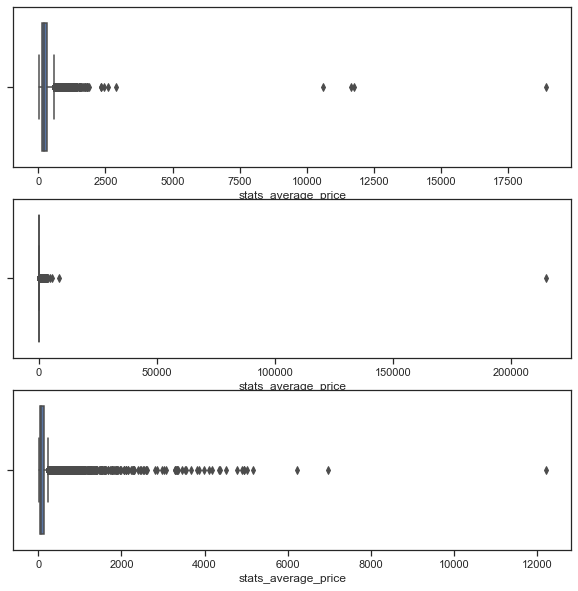

In [68]:
fig, axes = plt.subplots(3,1, figsize = (10,10))

for event, ax in zip(df['taxonomies_name'].unique(), axes.flat):
    sns.boxplot(df[df['taxonomies_name'] == event]['stats_average_price'], ax=ax);

In [69]:
df_filtered = df[~df['stats_average_price'].isnull()]
df_filtered = df[~df['stats_lowest_sg_base_price'].isnull()]

df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86448 entries, 0 to 114367
Data columns (total 89 columns):
access_method                            13775 non-null object
announce_date                            86448 non-null object
announcements                            86448 non-null object
conditional                              86448 non-null bool
created_at                               86448 non-null object
date_tbd                                 86448 non-null bool
datetime_local                           86448 non-null object
datetime_tbd                             86448 non-null bool
datetime_utc                             86448 non-null object
description                              18 non-null object
enddatetime_utc                          0 non-null float64
event_promotion                          0 non-null float64
general_admission                        7789 non-null object
id                                       86448 non-null int64
is_open                  

# Filtering off of Z-score

In [70]:
z_scores = np.abs(stats.zscore(df_filtered['stats_average_price']))
threshold = 2
print(np.where(z_scores >= threshold))
z_scores

(array([ 1035,  1281,  2892,  3068,  5828,  6200,  6764,  7052,  7737,
        8154,  8342,  8431,  9519,  9520,  9521,  9522,  9523,  9524,
        9525,  9976,  9977,  9978,  9979,  9980,  9981,  9983, 10053,
       10438, 11011, 11930, 12574, 14272, 14273, 14274, 14275, 14277,
       14278, 14284, 14695, 14697, 14699, 14700, 14701, 14702, 14704,
       15143, 15617, 15660, 16409, 16884, 17072, 17466, 17631, 17670,
       18075, 18532, 19654, 19700, 20254, 20917, 21150, 21210, 21229,
       21838, 22390, 22494, 22886, 23932, 24463, 24715, 25072, 25074,
       25337, 25565, 25923, 26547, 26634, 27233, 27686, 29275, 31225,
       31863, 32156, 32204, 34978, 37136, 38838, 42102, 45113, 47178,
       47646, 47680, 49854, 53447, 56855, 57006, 57242, 57433, 57515,
       57994, 58051, 58510, 58659, 59346, 59857, 60072, 60936, 62450,
       66788, 66981, 67027, 67565, 67757, 69336, 70852, 70894, 70908,
       71413, 72884, 73067, 73203, 73352, 73533, 73534, 73812, 75497,
       75498, 75746

array([0.20237894, 0.19061049, 0.05652682, ..., 0.07031085, 0.2742972 ,
       0.2742972 ])

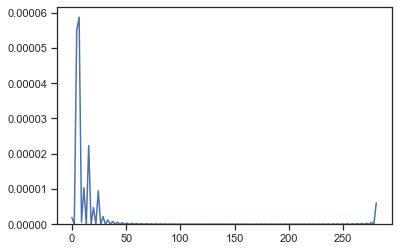

In [71]:
sns.kdeplot(z_scores);

In [72]:
# Filter by Z-Score: https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba
df_filtered = df_filtered[(z_scores < threshold)]
len(df_filtered)

86305

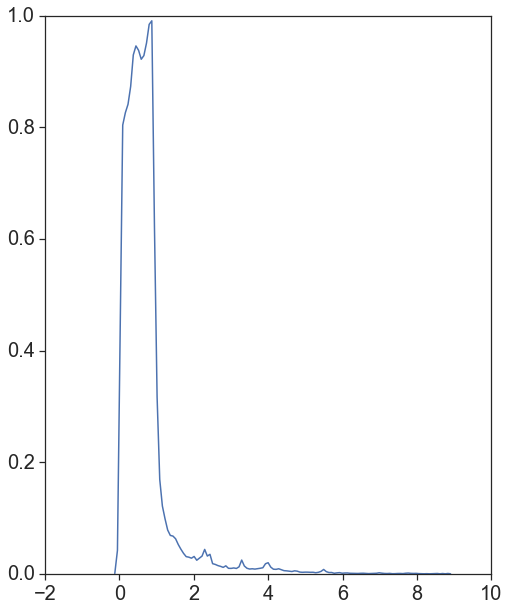

In [187]:
sns.kdeplot(np.abs(stats.zscore(df_filtered['stats_average_price'])));

theater
concert
sports


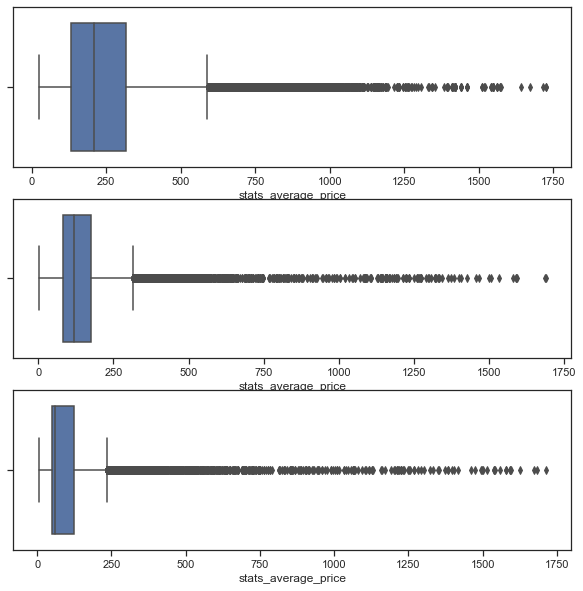

In [73]:
fig, axes = plt.subplots(3,1, figsize = (10,10))

for event, ax in zip(df_filtered['taxonomies_name'].unique(), axes.flat):
    print(event)
    sns.boxplot(df_filtered[df_filtered['taxonomies_name'] == event]['stats_average_price'], ax=ax);

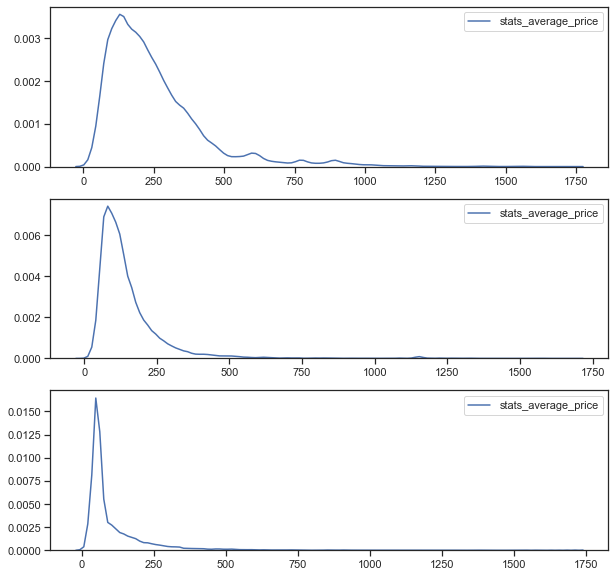

In [74]:
fig, axes = plt.subplots(3,1, figsize = (10,10))

for event, ax in zip(df_filtered['taxonomies_name'].unique(), axes.flat):
    sns.kdeplot(df_filtered[df_filtered['taxonomies_name'] == event]['stats_average_price'], ax=ax);

In [75]:
genres_avgprice = df_filtered[~df_filtered['taxonomies_name'].isnull()][['taxonomies_name','stats_average_price']]
genres_avgprice


groupedtickets = {}

#Making arrays of tick prices per genre for kw test
for grp in genres_avgprice.taxonomies_name.unique():
    groupedtickets[grp] = genres_avgprice['stats_average_price'][genres_avgprice['taxonomies_name']==grp].values
    print(str(grp) + " " + str(genres_avgprice[genres_avgprice['taxonomies_name']==grp]['stats_average_price'].mean()))

# print(groupedtickets)

args = groupedtickets.values()
            
H,p = stats.kruskal(*args)

print("\nKruskal")
print(H,p)

theater 252.6634114715238
concert 152.76762013228787
sports 113.63099369643743

Kruskal
20558.72472311233 0.0


I think taxnomie name has to do something with average price!

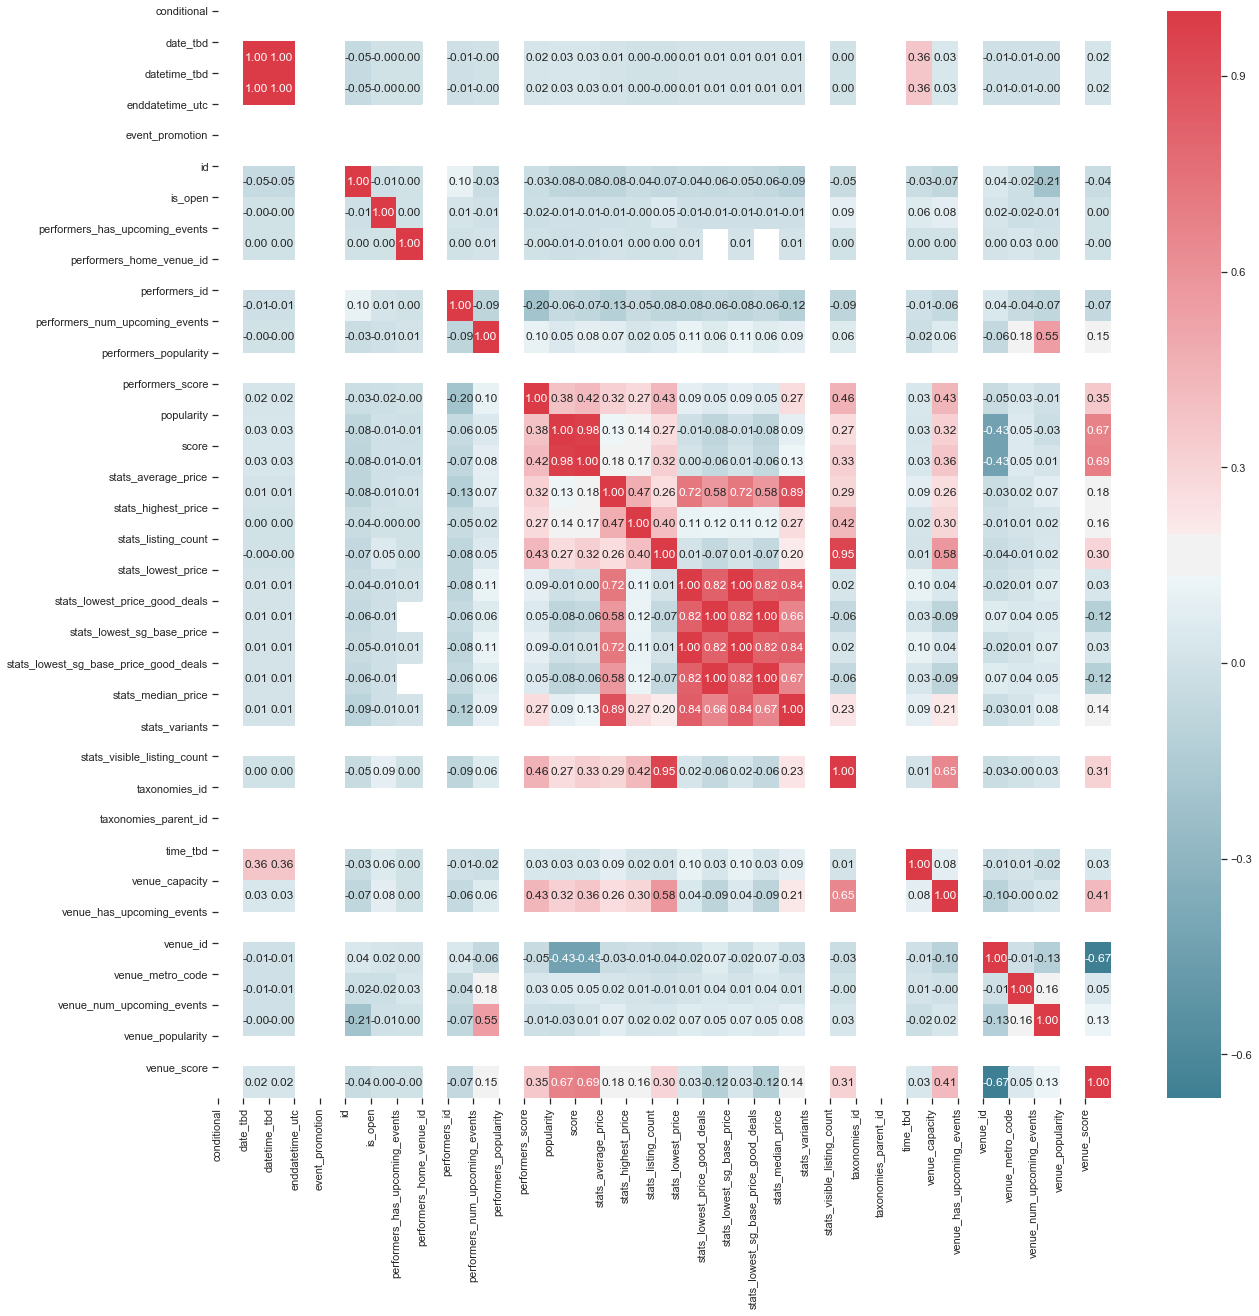

In [76]:
corrplot = heatMap(df_filtered[df_filtered['taxonomies_name'] == 'concert'], filename = 'heatmap_concerttix.png');

In [77]:
features= ['datetime_local', 'stats_average_price',
       'performers_genres', 'performers_has_upcoming_events',
       'performers_num_upcoming_events', 'performers_type',
       'popularity', 'score', 
       'stats_dq_bucket_counts', 'stats_highest_price', 'stats_listing_count',
       'stats_lowest_price', 
       'stats_lowest_sg_base_price', 'stats_lowest_sg_base_price_good_deals',
       'stats_median_price','stats_visible_listing_count',
        'venue_capacity', 'venue_city',
       'venue_location', 'venue_name', 'venue_postal_code',
       'venue_score', 'venue_state']


df_filtered[features].corr()

stats_average_price  \
stats_average_price                               1.000000   
performers_has_upcoming_events                    0.003732   
performers_num_upcoming_events                    0.373457   
popularity                                        0.104761   
score                                             0.163541   
stats_highest_price                               0.284784   
stats_listing_count                               0.133915   
stats_lowest_price                                0.721800   
stats_lowest_sg_base_price                        0.725041   
stats_lowest_sg_base_price_good_deals             0.691588   
stats_median_price                                0.935438   
stats_visible_listing_count                       0.120180   
venue_capacity                                   -0.026191   
venue_score                                       0.205513   

                                       performers_has_upcoming_events  \
stats_average_price                                          0.003732   
performers_has_upcoming_events                               1.000000   
performers_num_upcoming_events                               0.002973   
popularity                                                  -0.007803   
score                                                       -0.004195   
stats_highest_price                                          0.001061   
stats_listing_count                                          0.002136   
stats_lowest_price                                           0.003613   
stats_lowest_sg_base_price                                   0.003659   
stats_lowest_sg_base_price_good_deals                             NaN   
stats_median_price                                           0.003648   
stats_visible_listing_count                                  0.002233   
venue_capacity                                               0.001711   
venue_score                                                 -0.000352   

                                       performers_num_upcoming_events  \
stats_average_price                                          0.373457   
performers_has_upcoming_events                               0.002973   
performers_num_upcoming_events                               1.000000   
popularity                                                   0.049078   
score                                                        0.096215   
stats_highest_price                                          0.031494   
stats_listing_count                                         -0.001572   
stats_lowest_price                                           0.294657   
stats_lowest_sg_base_price                                   0.295314   
stats_lowest_sg_base_price_good_deals                        0.325959   
stats_median_price                                           0.392800   
stats_visible_listing_count                                 -0.014146   
venue_capacity                                              -0.124462   
venue_score                                                  0.033090   

                                       popularity     score  \
stats_average_price                      0.104761  0.163541   
performers_has_upcoming_events          -0.007803 -0.004195   
performers_num_upcoming_events           0.049078  0.096215   
popularity                               1.000000  0.939775   
score                                    0.939775  1.000000   
stats_highest_price                      0.153625  0.178630   
stats_listing_count                      0.375766  0.417883   
stats_lowest_price                      -0.027692  0.011404   
stats_lowest_sg_base_price              -0.031026  0.008456   
stats_lowest_sg_base_price_good_deals   -0.124060 -0.079862   
stats_median_price                       0.059148  0.112408   
stats_visible_listing_count              0.368535  0.422565   
venue_capacity                           0.319054  0.350037   
venue_score                       

In [78]:
len(features)

23

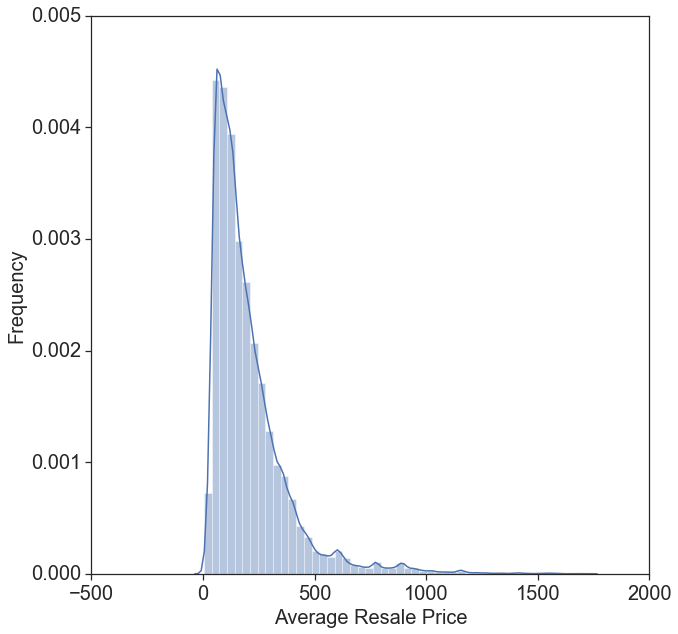

In [186]:
fig, ax = plt.subplots(figsize=(10,10))

sns.distplot(df_filtered['stats_average_price']);
plt.xlabel('Average Resale Price', fontsize = 20)
plt.ylabel('Frequency', fontsize = 20)
plt.savefig('dist_avgprice.png')

In [80]:
df_filtered['stats_average_price'].mean()

203.49453681710213

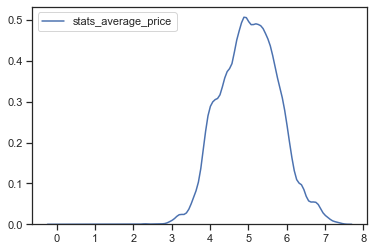

In [81]:
sns.kdeplot(np.log(df_filtered['stats_average_price']))

In [82]:
import datetime

download_date = datetime.date(2019, 10, 8)
df_filtered['datetime_local'] =  pd.to_datetime(df_filtered['datetime_local']).dt.date

df_filtered
df_filtered['days_to_event'] = df_filtered['datetime_local'] - download_date
df_filtered['days_to_event'] = df_filtered['days_to_event'].dt.days

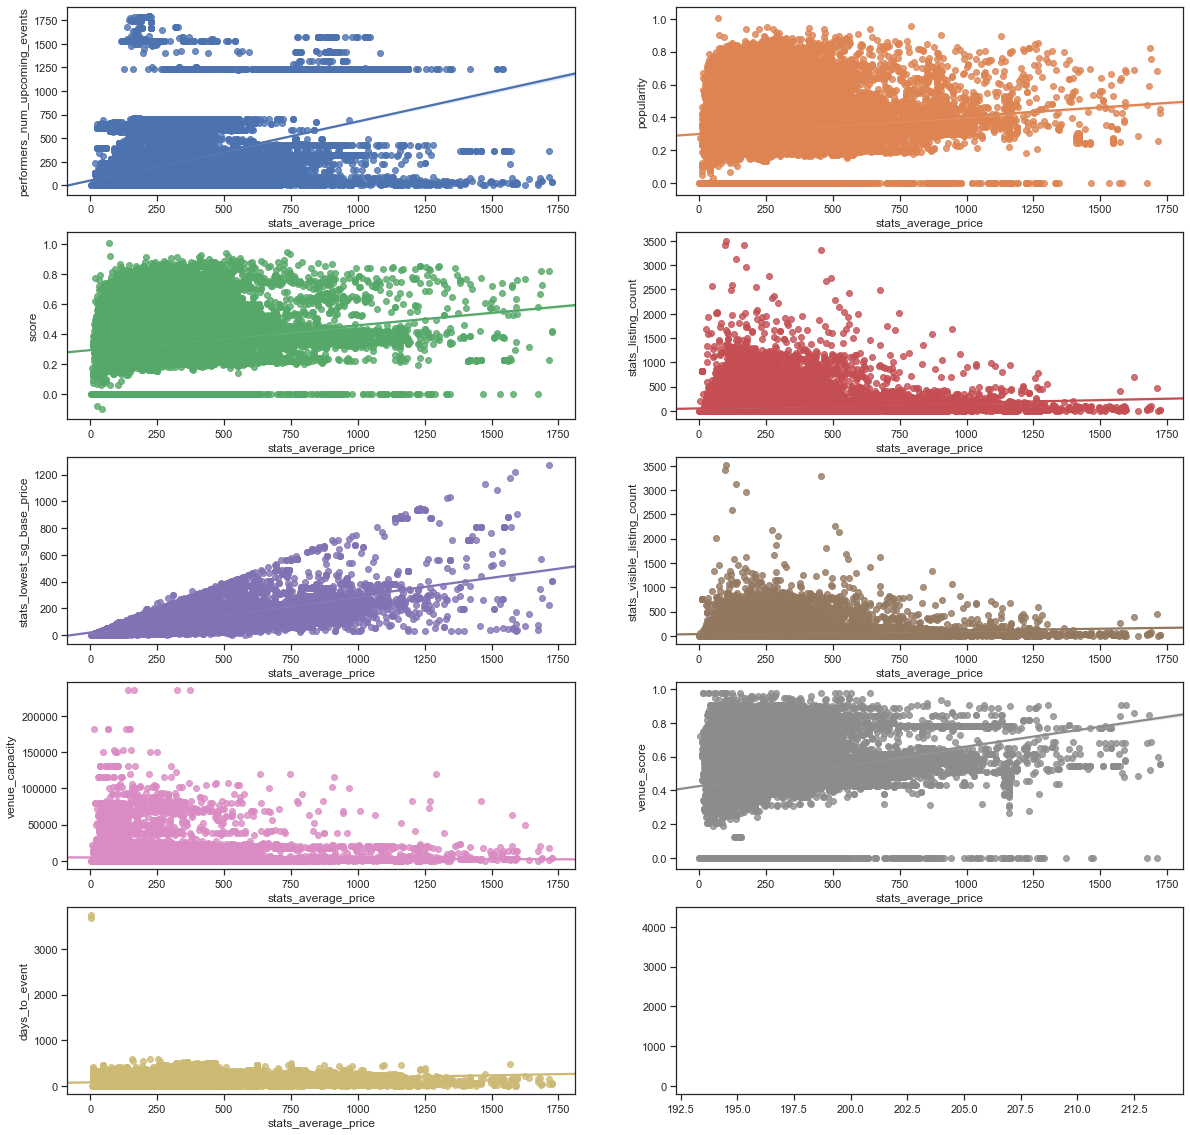

In [83]:
# let's look at log transforming
features= [
       'performers_num_upcoming_events',
       'popularity', 'score', 
       'stats_listing_count',
       'stats_lowest_sg_base_price',
       'stats_visible_listing_count',
        'venue_capacity',
       'venue_score','days_to_event']

fig, axes = plt.subplots(5,2, figsize=(20,20))

for measure,ax in zip(features, axes.flat):
    sns.regplot(df_filtered['stats_average_price'], df_filtered[measure], ax = ax);

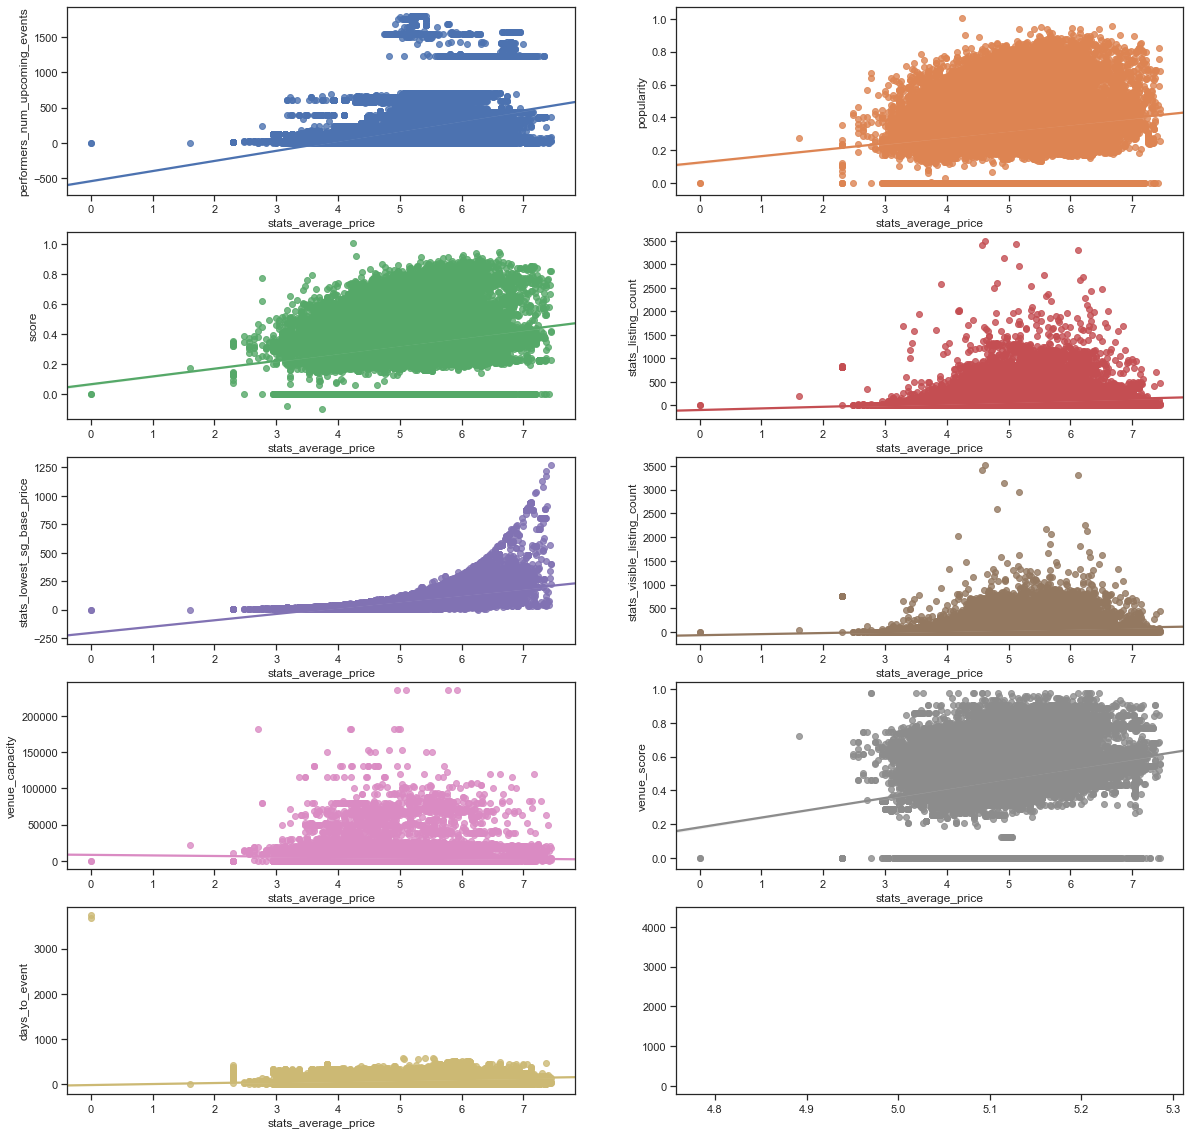

In [84]:
fig, axes = plt.subplots(5,2, figsize=(20,20))
for measure,ax in zip(features, axes.flat):
    sns.regplot(np.log(df_filtered['stats_average_price']), df_filtered[measure], ax = ax);

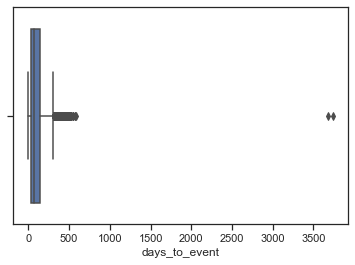

In [85]:
sns.boxplot(df_filtered['days_to_event'])

In [86]:
# filter out events that are more than 1000 days out
df_filtered = df_filtered[df_filtered['days_to_event'] < 1000]

df_filtered[features].isnull().sum()

performers_num_upcoming_events    0
popularity                        0
score                             0
stats_listing_count               0
stats_lowest_sg_base_price        0
stats_visible_listing_count       0
venue_capacity                    0
venue_score                       0
days_to_event                     0
dtype: int64

# Trying most simple Linear Regression

In [87]:
df_filtered_concert = df_filtered[df_filtered['taxonomies_name'] == 'concert']

In [88]:
# train test split

y = df_filtered_concert['stats_average_price']
X = df_filtered_concert.drop('stats_average_price', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.10, random_state = 193)

In [89]:
def linear_regression(X_train, y_train, X_test, y_test):
    model = LinearRegression().fit(X_train, y_train)
    model.score(X_train, y_train)
    
    # Coeff
    print(model.get_params)
    print(model.coef_)
    
    # Making Predictions using the testing set
    y_pred = model.predict(X_test)
   
    # Mean squared error
    print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
    
    # R2
    print("R2: %2f" % r2_score(y_test, y_pred))
    
    #Let's try to studentize them: divide the resideual by the estimate of the stdev of the residuals. 
    fig, ax = plt.subplots()
    fig.set_size_inches(10,8)
    mask_outliers = studresidplot(model,X_train,y_train,threshold=2, ax = ax)
    
    #QQ plot: to chck if residuals are not normally distributed
    vals = {'Studentized Residuals': (y_train-model.predict(X_train))/rse(model,X_train,y_train), 'Predicted Values': model.predict(X_train)}

    ax = sm.graphics.qqplot(vals['Studentized Residuals'], line='45')
    
    # VIF
#     print("VIF: %2f" % variance_inflation_factor(X_train.values,1))


# Venue Score

<bound method BaseEstimator.get_params of LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)>
[110.7510991]
Mean squared error: 7211.46
R2: 0.042688


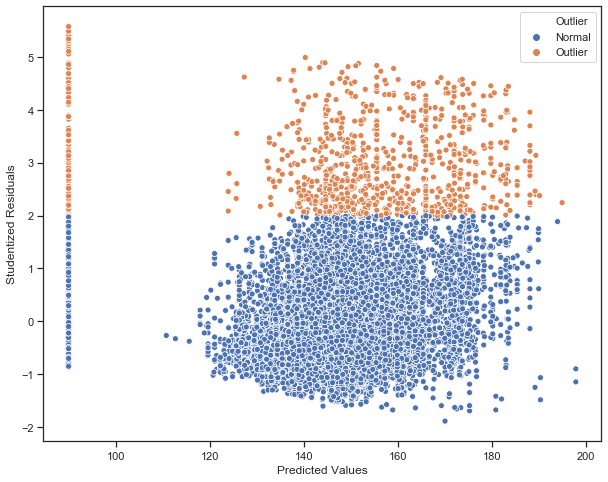

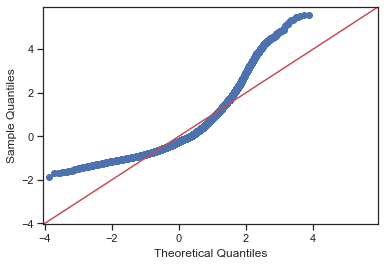

In [193]:
feats1 = ['venue_score']
linear_regression(X_train[feats1], y_train, X_test[feats1], y_test)

<bound method BaseEstimator.get_params of LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)>
[0.76576885]
Mean squared error: 0.28
R2: 0.062132


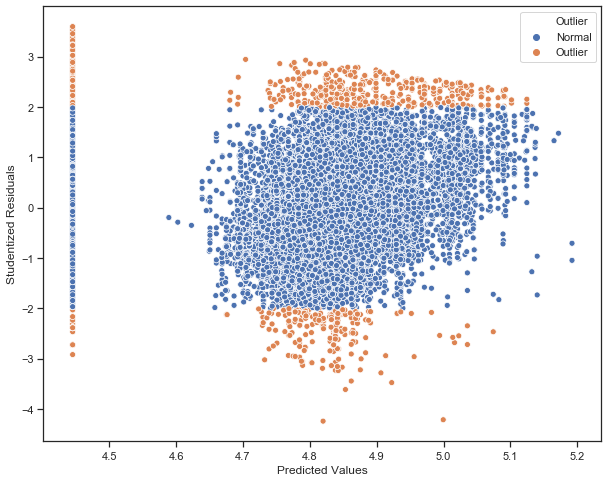

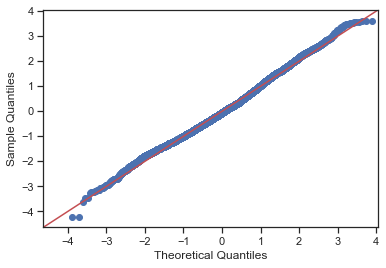

In [194]:
linear_regression(X_train[feats1], np.log(y_train), X_test[feats1], np.log(y_test))

# Venue Capacity

<bound method BaseEstimator.get_params of LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)>
[0.00467135]
Mean squared error: 6747.17
R2: 0.104321


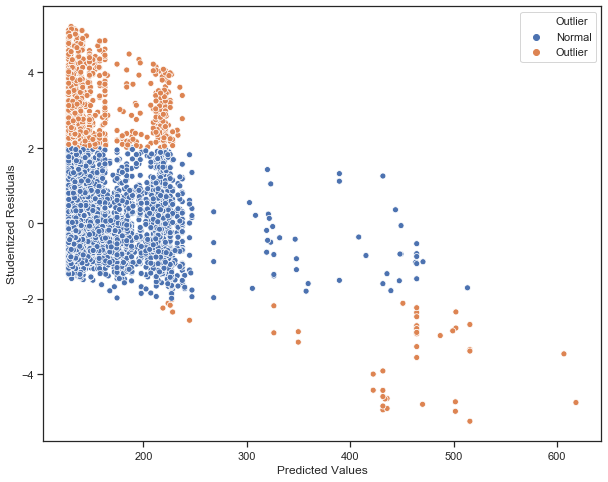

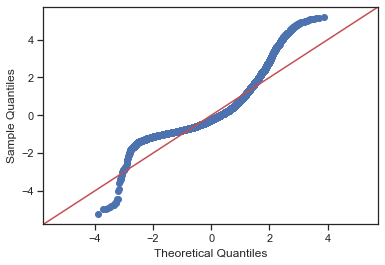

In [195]:
feats2 = ['venue_capacity']
linear_regression(X_train[feats2], y_train, X_test[feats2], y_test)

<bound method BaseEstimator.get_params of LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)>
[2.78281912e-05]
Mean squared error: 0.27
R2: 0.097995


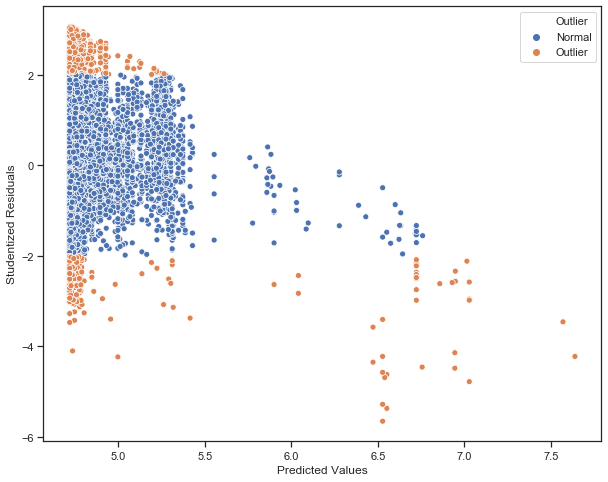

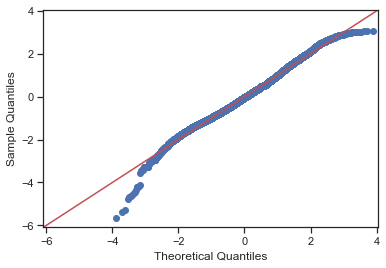

In [196]:
linear_regression(X_train[feats2], np.log(y_train), X_test[feats2], np.log(y_test))

# Base price

<bound method BaseEstimator.get_params of LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)>
[0.00964874]
Mean squared error: 0.19
R2: 0.369074


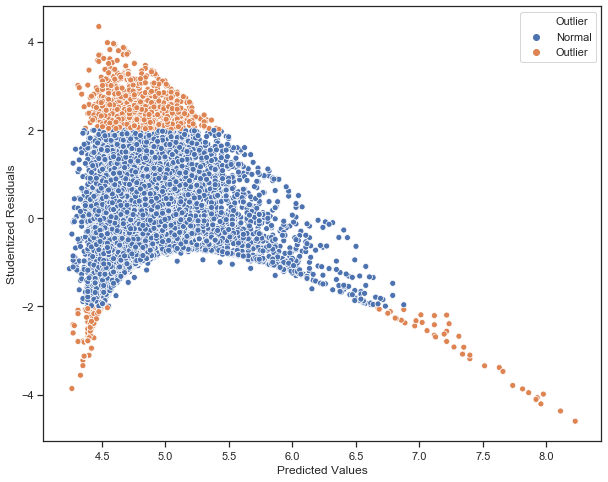

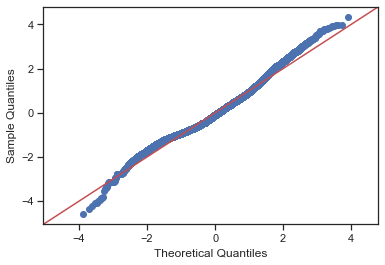

In [197]:
feats3 = ['stats_lowest_sg_base_price']
linear_regression(X_train[feats3], np.log(y_train), X_test[feats3], np.log(y_test))

<bound method BaseEstimator.get_params of LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)>
[0.71358764]
Mean squared error: 0.17
R2: 0.420357


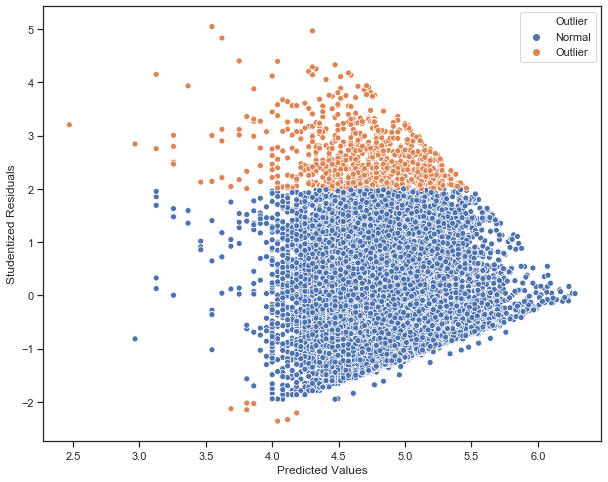

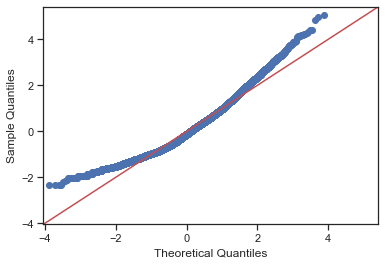

In [199]:
linear_regression(np.log(X_train[feats3]), np.log(y_train), np.log(X_test[feats3]), np.log(y_test))

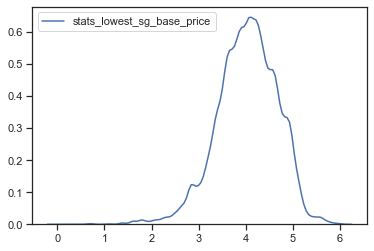

In [200]:
sns.kdeplot(np.log(df_filtered['stats_lowest_sg_base_price']))

# Days since announcement

<bound method BaseEstimator.get_params of LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)>
[0.40198887]
Mean squared error: 7041.02
R2: 0.065313


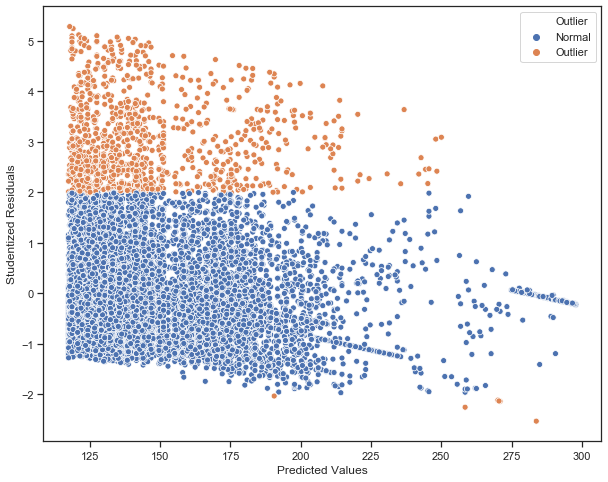

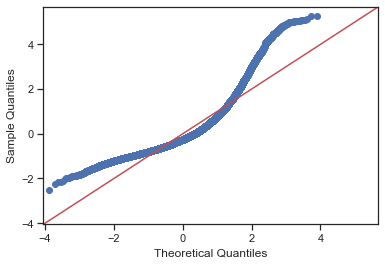

In [201]:
feats3 = ['days_to_event']
linear_regression(X_train[feats3], y_train, X_test[feats3], y_test)

# Score

<bound method BaseEstimator.get_params of LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)>
[0.6646236]
Mean squared error: 0.28
R2: 0.056884


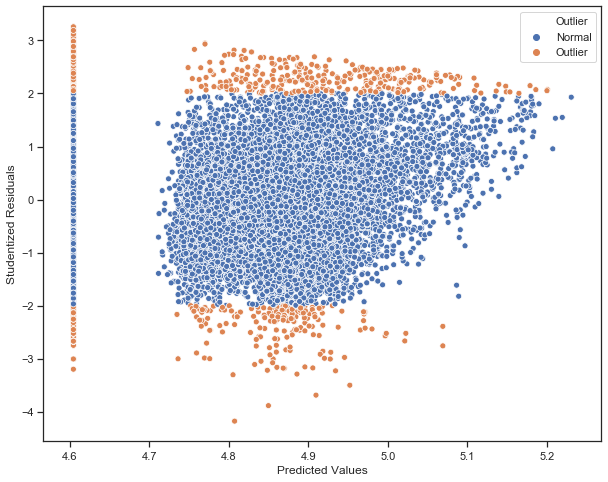

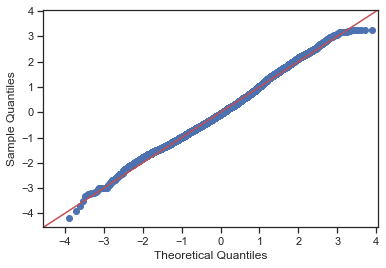

In [202]:
feats4 = ['score']
linear_regression(X_train[feats4], np.log(y_train), X_test[feats4], np.log(y_test))

# stats_visible_listing_count

<bound method BaseEstimator.get_params of LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)>
[0.42930338]
Mean squared error: 6389.00
R2: 0.151868


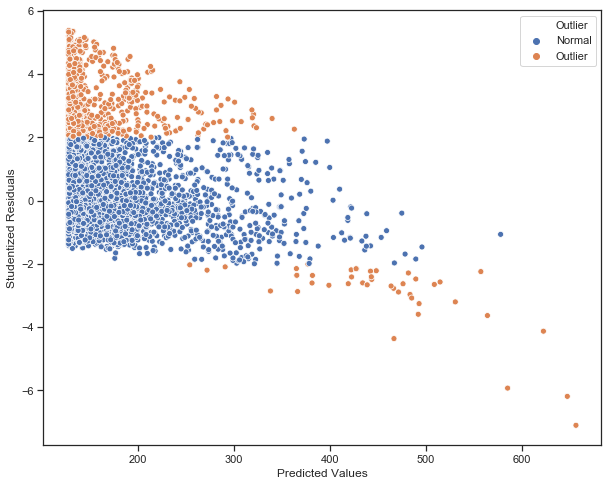

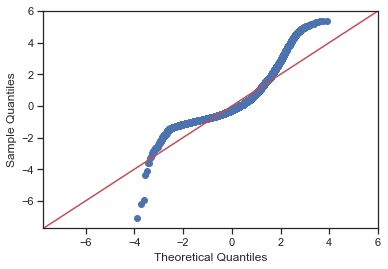

In [223]:
feats5 = ['stats_visible_listing_count']
linear_regression(X_train[feats5], y_train, X_test[feats5], y_test)

<bound method BaseEstimator.get_params of LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)>
[0.00252656]
Mean squared error: 0.26
R2: 0.125434


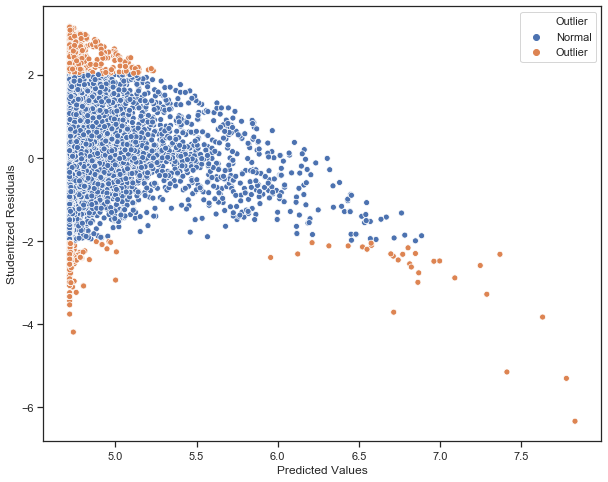

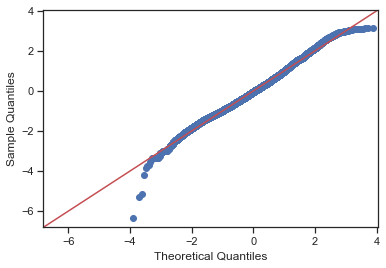

In [224]:
linear_regression(X_train[feats5], np.log(y_train), X_test[feats5], np.log(y_test))

# Random Forest Try

In [90]:
X_train[features]

performers_num_upcoming_events  popularity  score  \
32987                               19       0.000  0.000   
6371                                29       0.563  0.432   
78490                               16       0.414  0.377   
58911                               15       0.334  0.314   
29433                               10       0.284  0.236   
7840                                15       0.344  0.282   
82858                               24       0.503  0.476   
5008                                40       0.602  0.495   
76483                                6       0.330  0.366   
33674                               28       0.287  0.243   
31414                               15       0.397  0.355   
28369                               29       0.000  0.000   
26387                               34       0.000  0.000   
52855                                4       0.354  0.360   
45213                               31       0.000  0.000   
38276                               14       0.000  0.000   
9610                                16       0.323  0.252   
75353                               19       0.226  0.218   
89                                  27       0.426  0.337   
25997                               20       0.000  0.000   
13044                                9       0.000  0.000   
85291                               49       0.549  0.597   
74086                               14       0.211  0.200   
38394                               21       0.467  0.410   
27216                                3       0.483  0.418   
15827                               10       0.325  0.372   
3144                                34       0.524  0.385   
34575                               19       0.535  0.495   
14192                               10       0.387  0.300   
13180                               24       0.000  0.000   
...                                ...         ...    ...   
793                                 35       0.000  0.000   
32602                               11       0.317  0.284   
30948                               17       0.352  0.305   
73978                                4       0.000  0.000   
40872                               14       0.000  0.000   
27294                               32       0.356  0.311   
3076                                12       0.405  0.335   
30071                               32       0.366  0.326   
25683                                2       0.000  0.000   
11868                               22       0.291  0.221   
73376                                4       0.000  0.000   
15460                               16       0.000  0.000   
7995                                27       0.497  0.448   
29268                                5       0.480  0.432   
58276                               23       0.237  0.221   
104901                              44       0.362  0.353   
91956                               11       0.267  0.315   
2929                                16       0.000  0.000   
87975                                5       0.347  0.374   
35328                                5       0.404  0.375   
34191                                2       0.000  0.000   
15941                                5       0.519  0.426   
43438                               20       0.422  0.380   
7597                                22       0.310  0.234   
15066                               17       0.000  0.000   
76445                               26       0.430  0.396   
41596                               19       0.267  0.239   
95487                                2       0.000  0.000   
51908                                2       0.277  0.238   
49578                               40       0.326  0.310   

        stats_listing_count  stats_lowest_sg_base_price  \
32987                  29.0                        49.0   
6371                    9.0                        30.0   
78490                  20.0                     

In [91]:
# Test random forest

#Train and fit model
rf = RandomForestRegressor(n_estimators = 1000,
                           max_features = 'auto',
                           random_state = 0
                            )

In [92]:
rf.fit(X_train[features], y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [93]:
rf_pred = rf.predict(X_test[features])

In [94]:
print(f"accuracy = {rf.score(X_test[features], y_test)}")

accuracy = 0.7683850008980327


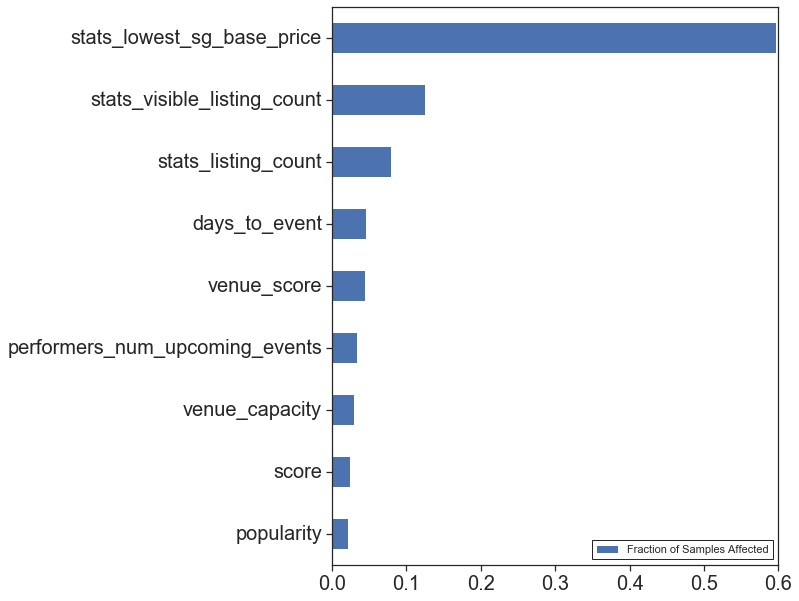

In [179]:
# Plot feature importance
feat_scores = pd.DataFrame({'Fraction of Samples Affected' : rf.feature_importances_}, index=X_train[features].columns)
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

feat_scores = feat_scores.sort_values(by='Fraction of Samples Affected')
feat_scores.plot(kind='barh');
plt.savefig('rf_feat_importance.png', bbox_inches='tight')

In [232]:
# Trying a parameter search
model = RandomForestRegressor()

param_grid = {
    "n_estimators": [10, 100, 1000], # num of trees
    "max_depth": [5,10],
    "max_features": ['auto'] # num of features when considering where to split
}

grid_search = GridSearchCV(model, param_grid=param_grid, cv=5, iid=False)
start = time()
grid_search.fit(X_train[features], y_train)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))

GridSearchCV took 400.07 seconds for 6 candidate parameter settings.


In [233]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            
report(grid_search.cv_results_)

Model with rank: 1
Mean validation score: 0.703 (std: 0.015)
Parameters: {'max_depth': 10, 'max_features': 'auto', 'n_estimators': 1000}

Model with rank: 2
Mean validation score: 0.702 (std: 0.017)
Parameters: {'max_depth': 10, 'max_features': 'auto', 'n_estimators': 100}

Model with rank: 3
Mean validation score: 0.690 (std: 0.015)
Parameters: {'max_depth': 10, 'max_features': 'auto', 'n_estimators': 10}



In [96]:
#Train and fit model
rf_gs = RandomForestRegressor(n_estimators = 1000,
                           max_features = 'auto',
                           random_state = 0,
                            max_depth = 10
                            )
rf_gs.fit(X_train[features], y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [97]:
rf_gs_pred = rf_gs.predict(X_test[features])
print(f"accuracy = {rf_gs.score(X_test[features], y_test)}")

accuracy = 0.754740331556654


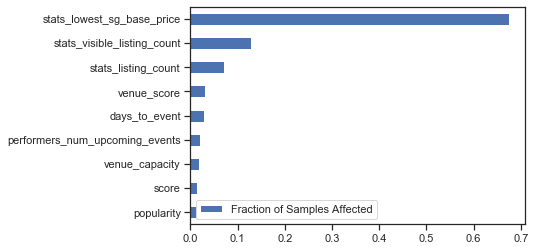

In [98]:
# Plot feature importance
feat_scores_gs = pd.DataFrame({'Fraction of Samples Affected' : rf_gs.feature_importances_}, index=X_train[features].columns)

feat_scores_gs = feat_scores_gs.sort_values(by='Fraction of Samples Affected')
feat_scores_gs.plot(kind='barh')

# Let's use the RF to Inform the Linear Regression before doing Lasso

<bound method BaseEstimator.get_params of LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)>
[1.48510678 0.41264214]
Mean squared error: 3859.79
R2: 0.487617


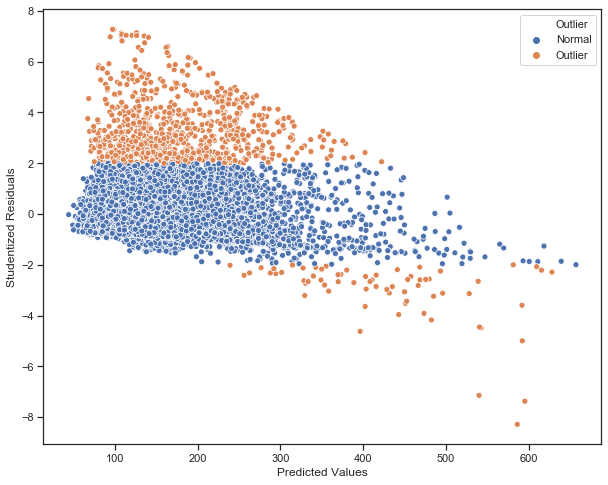

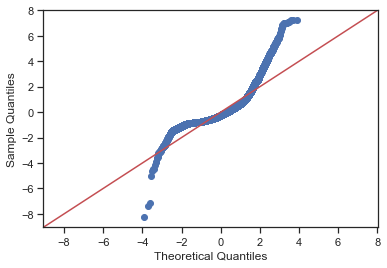

In [227]:
feats6 = ['stats_lowest_sg_base_price', 'stats_visible_listing_count']
linear_regression(X_train[feats6], y_train, X_test[feats6], y_test)

<bound method BaseEstimator.get_params of LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)>
[0.00951744 0.00241979]
Mean squared error: 0.15
R2: 0.482635


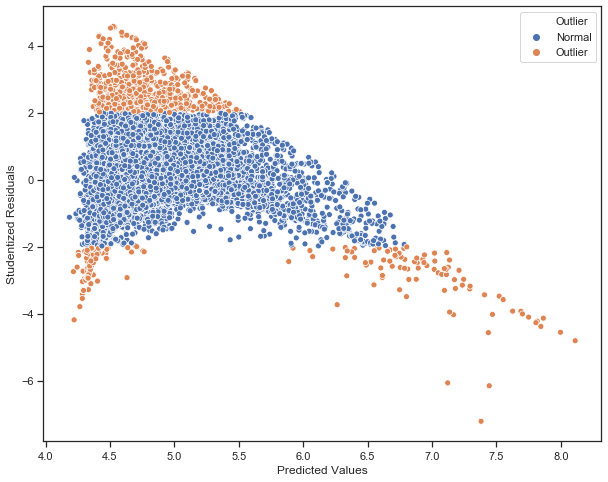

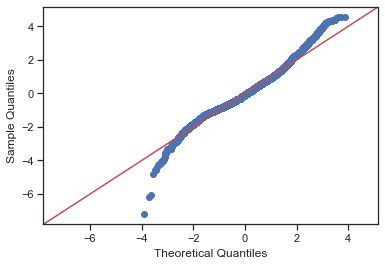

In [228]:
linear_regression(X_train[feats6], np.log(y_train), X_test[feats6], np.log(y_test))

Maybe a transformation will work?

## Lasso

In [99]:
lasso = Lasso()
lasso.fit(X_train[features], y_train)

train_score=lasso.score(X_train[features],y_train)
test_score=lasso.score(X_test[features],y_test)
coeff_used = np.sum(lasso.coef_!=0)
print("training score: " + str(train_score)) 
print("test score: " + str(test_score))
print("number of features used: " + str(coeff_used))

training score: 0.6143678323191596
test score: 0.6383020299326724
number of features used: 7


In [100]:
lasso.get_params

<bound method BaseEstimator.get_params of Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)>

In [101]:
lasso.coef_

array([-1.60362667e-01,  0.00000000e+00,  3.41199964e+01, -3.74455798e-02,
        1.49200003e+00,  4.10188902e-01,  1.28750573e-03,  0.00000000e+00,
        2.17349760e-01])

In [102]:
lasso

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

Text(0.5, 1.0, 'Feature importance using Lasso Model')

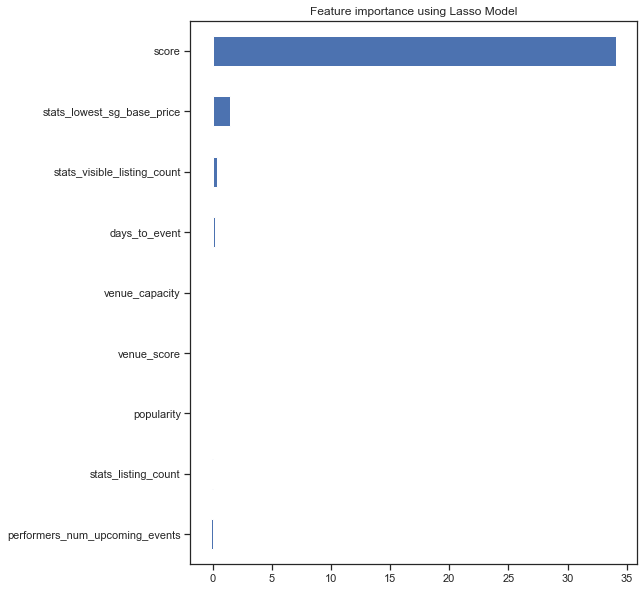

In [103]:
coef = pd.Series(lasso.coef_, index=X_train[features].columns)
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

In [263]:
# Grid search

model = Lasso()

param_grid = {
    "alpha": [0.01, 0.1, 0.5, 1], # alpha: lasso constant
}

grid_search = GridSearchCV(model, param_grid=param_grid, cv=5, iid=False)
start = time()
grid_search.fit(X_train[features], y_train)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))


GridSearchCV took 0.56 seconds for 4 candidate parameter settings.


In [264]:
report(grid_search.cv_results_)

Model with rank: 1
Mean validation score: 0.567 (std: 0.021)
Parameters: {'alpha': 0.01}

Model with rank: 2
Mean validation score: 0.562 (std: 0.022)
Parameters: {'alpha': 0.1}

Model with rank: 3
Mean validation score: 0.558 (std: 0.021)
Parameters: {'alpha': 0.5}



In [104]:
# Lasso with best parameters from grid search
lasso_gs = Lasso(alpha=0.01)
lasso_gs.fit(X_train[features], y_train)

train_score=lasso_gs.score(X_train[features],y_train)
test_score=lasso_gs.score(X_test[features],y_test)
coeff_used = np.sum(lasso_gs.coef_!=0)
print("training score: " + str(train_score)) 
print("test score: " + str(test_score))
print("number of features used: " + str(coeff_used))

training score: 0.6190792829076288
test score: 0.6428450821881111
number of features used: 9


Text(0.5, 1.0, 'Feature importance using Lasso Model')

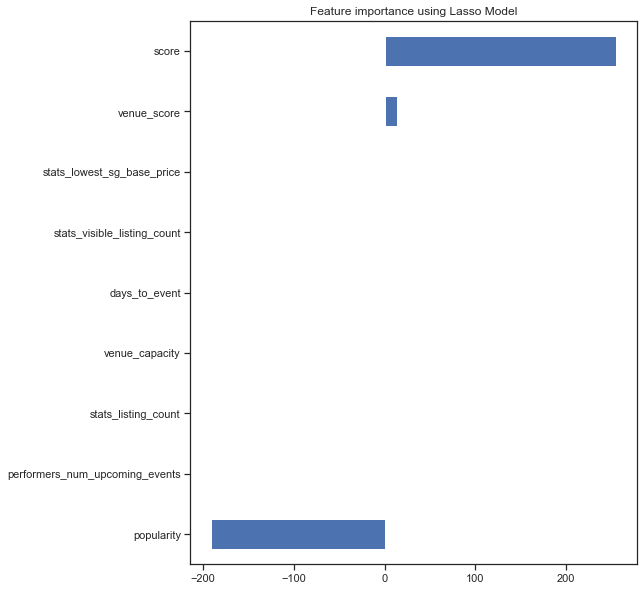

In [105]:
coef_gs = pd.Series(lasso_gs.coef_, index=X_train[features].columns)
imp_coef = coef_gs.sort_values()

matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

In [106]:
# With Standardized Data
# Lasso with best parameters from grid search along with transformation

scaler = preprocessing.StandardScaler().fit(X_train[features])
X_train_transformed = scaler.transform(X_train[features])

rgs = Lasso(alpha=0.01).fit(X_train_transformed, y_train)

X_test_transformed = scaler.transform(X_test[features])


train_score=rgs.score(X_train_transformed,y_train)
test_score=rgs.score(X_test_transformed,y_test)
coeff_used = np.sum(rgs.coef_!=0)
print("training score: " + str(train_score)) 
print("test score: " + str(test_score))
print("number of features used: " + str(coeff_used))

training score: 0.6190965505027437
test score: 0.642887359517254
number of features used: 9


Text(0.5, 1.0, 'Feature importance using Lasso Model w STD Feats')

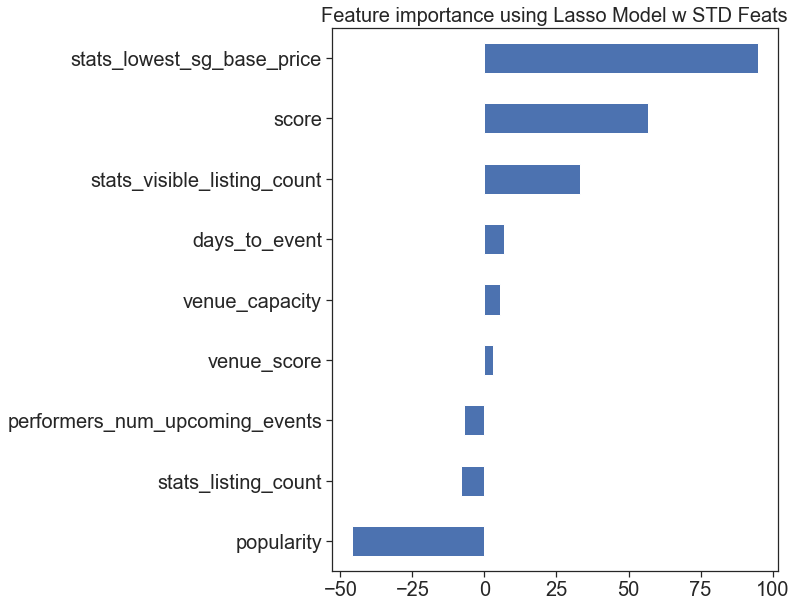

In [142]:
coef_std = pd.Series(rgs.coef_, index=X_train[features].columns)
imp_coef_std = coef_std.sort_values()

matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
imp_coef_std.plot(kind = "barh")
plt.title("Feature importance using Lasso Model w STD Feats", fontsize=20)

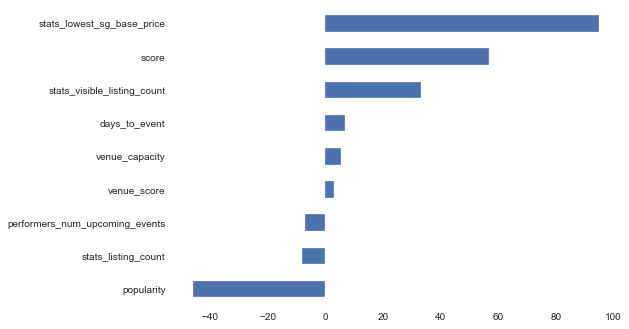

In [154]:
imp_coef_std.plot(kind = "barh").get_figure().savefig('LASSO_featimp_std.png', bbox_inches='tight')

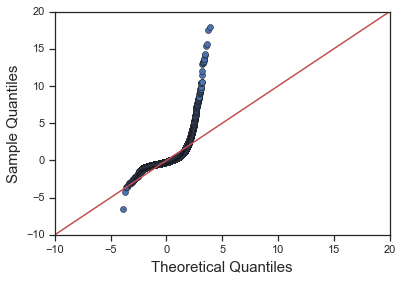

In [169]:
vals = {'Studentized Residuals': (y_train-rgs.predict(X_train_transformed))/rse(rgs,X_train_transformed,y_train), 'Predicted Values': rgs.predict(X_train_transformed)}
plt.rc('font', size=14)
plt.rc('figure', titlesize=18)
plt.rc('axes', labelsize=15)
plt.rc('axes', titlesize=18)

ax = sm.graphics.qqplot(vals['Studentized Residuals'], line='45')
plt.savefig("LASSO_qq_std.png")

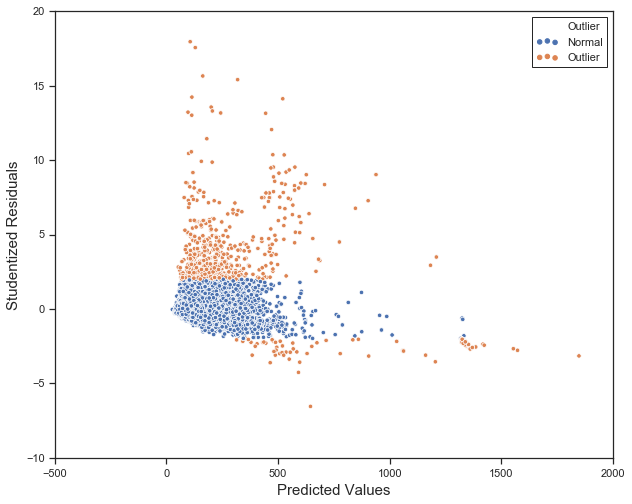

In [171]:
fig, ax = plt.subplots()
plt.rc('font', size=14)
plt.rc('figure', titlesize=18)
plt.rc('axes', labelsize=15)
plt.rc('axes', titlesize=18)
fig.set_size_inches(10,8)
mask_outliers = studresidplot(rgs,X_train_transformed,y_train,threshold=2, ax = ax)
plt.savefig("LASSO_residuals_std.png")

In [110]:
variance_inflation_factor(pd.DataFrame(X_train_transformed).values,1)

38.3943135746991

# Lasso with Standardiszed data and log transformed Y

In [111]:
# With Standardized Data
# Lasso with best parameters from grid search along with transformation

rgs_trans = Lasso(alpha=0.01).fit(X_train_transformed, np.log(y_train))


train_score=rgs_trans.score(X_train_transformed,np.log(y_train))
test_score=rgs_trans.score(X_test_transformed,np.log(y_test))
coeff_used = np.sum(rgs_trans.coef_!=0)
print("training score: " + str(train_score)) 
print("test score: " + str(test_score))
print("number of features used: " + str(coeff_used))

training score: 0.4933126280757695
test score: 0.4846648918259308
number of features used: 7


Text(0.5, 1.0, 'Feature importance using Lasso Model w STD Feats and logtrans y')

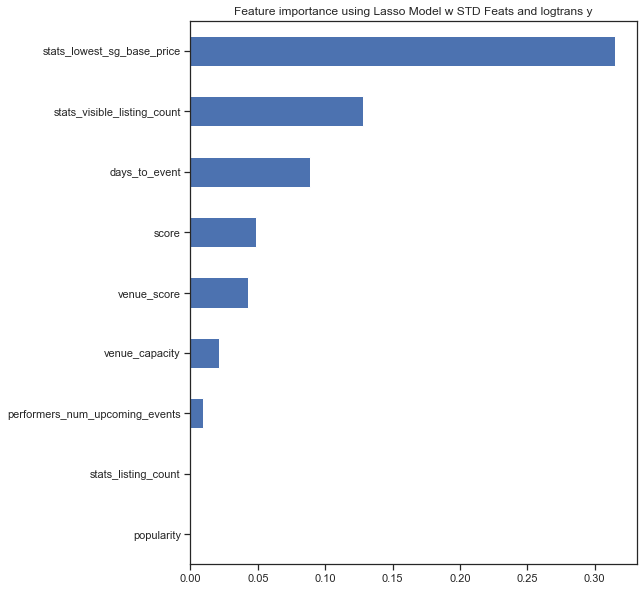

In [114]:
coef_std = pd.Series(rgs_trans.coef_, index=X_train[features].columns)
imp_coef_std = coef_std.sort_values()

matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef_std.plot(kind = "barh")
plt.title("Feature importance using Lasso Model w STD Feats and logtrans y")

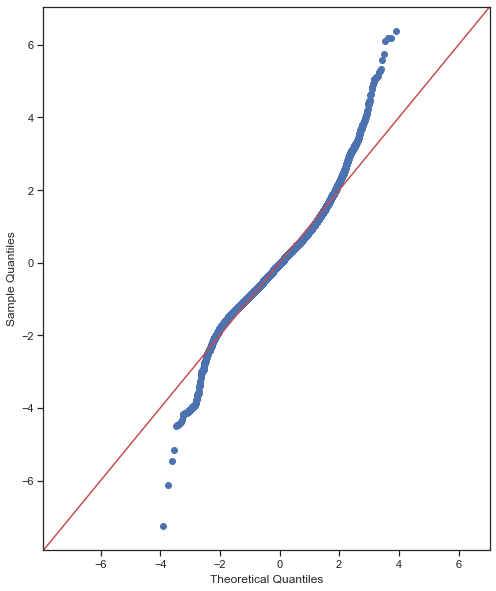

In [115]:
vals = {'Studentized Residuals': (np.log(y_train)-rgs_trans.predict(X_train_transformed))/rse(rgs_trans,X_train_transformed,np.log(y_train)), 'Predicted Values': rgs.predict(X_train_transformed)}

ax = sm.graphics.qqplot(vals['Studentized Residuals'], line='45')

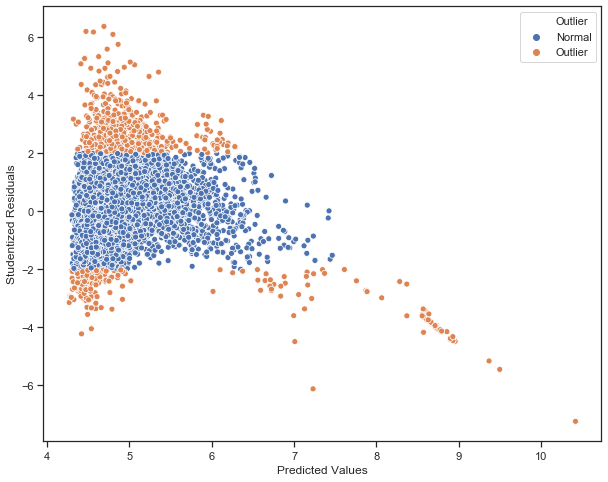

In [117]:
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
mask_outliers = studresidplot(rgs_trans,X_train_transformed,np.log(y_train),threshold=2, ax = ax)

In [118]:
variance_inflation_factor(pd.DataFrame(X_train_transformed).values,1)

38.3943135746991